# IMPORTS

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, date
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# PLOTTING PARAMETERS

In [2]:
plt.style.use("bmh")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
    )

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    )

# PATHS

In [3]:
path_data = Path('./input/store-sales-time-series-forecasting')

#  FUNCTIONS TO BE SET IN MODULE

In [4]:
def prepare_seasonal_plot(df):
    
    X = df.copy()

    # days within a week
    X["day"] = X.date.dt.dayofweek  # the x-axis (freq)
    X["week"] = X.date.dt.week  # the seasonal period (period)

    # days within a year
    X["dayofyear"] = X.date.dt.dayofyear
    X["year"] = X.date.dt.year

    return X

def seasonal_plot(X, y, period, freq, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

# DATA

## Store_sales

In [5]:
store_sales = pd.read_csv(
    path_data / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={'store_nbr': 'category',
           'family': 'category',
           'sales': 'float32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(store_sales['date'])

store_sales = prepare_seasonal_plot(store_sales)

/tmp/ipykernel_87942/700188254.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  X["week"] = X.date.dt.week  # the seasonal period (period)


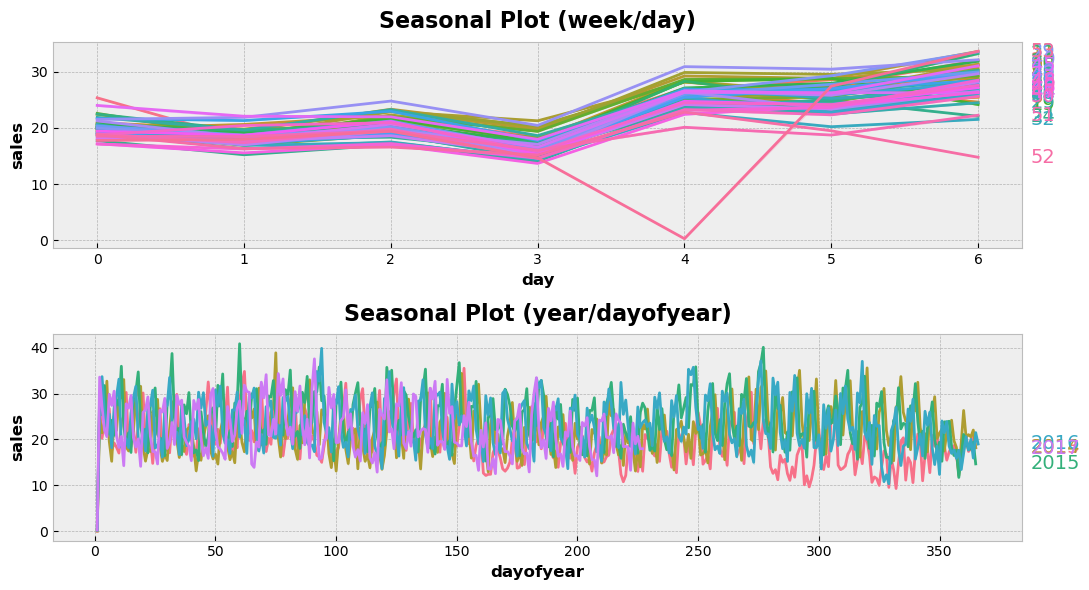

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(store_sales.query("family == 'SEAFOOD'"), y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(store_sales.query("family == 'SEAFOOD'"), y="sales", period="year", freq="dayofyear", ax=ax1);

## Stores

In [7]:
stores = pd.read_csv(
    path_data / 'stores.csv',
    dtype={'store_nbr': 'category',
           'city': 'category',
           'state': 'category',
           'type': 'category',
           'cluster': 'category'
           },
    )
# type already use as column name
stores.rename(columns={'type': 'store_type'}, inplace=True)
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Test data

In [8]:
df_test = pd.read_csv(
    path_data / 'test.csv',
    dtype={'store_nbr': 'category',
           'family': 'category',
           'onpromotion': 'uint32',
           },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(df_test['date'])
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Holidays_events

#### DATA DESCRIPTION

Holidays and Events, with metadata

NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

ADDITIONAL NOTES:

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.



In [29]:
holidays_events = pd.read_csv(
    path_data / "holidays_events.csv",
    dtype={'type': 'category',
          'locale': 'category',
          'locale_name': 'category',
          'description': 'category',
          'transferred': 'bool',#
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(holidays_events['date'])
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
### TBD IT TURNS OUT THAT FOR A FEW ENTRIES (DAYS), TWO EVENTS OCCUR ON THE SAME DAY ###
### To preserve this information, we create a new description columns ###
### at the end we rename bridge as additional, get rid of description, and drop duplicates

In [30]:
holidays_events.type.unique()

['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']
Categories (6, object): ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day']

- 'Holiday'are holiday, 
- 'Work Day' are extra, unusual work days, meant to compensate for Bridge days 

We create a 'status' column to specify if the given day is a work day or a holiday 

In [33]:
holidays_events['status'] = np.nan
holidays_events.loc[holidays_events.type=='Holiday', 'status'] = 'holiday'
holidays_events.loc[holidays_events.type=='Work Day', 'status'] = 'work'

- 'Bridge' are holidays

In [43]:
# visualize the issue
bridge_mask = holidays_events.type == 'Bridge'
bridge = holidays_events[bridge_mask]
bridge

,date,type,locale,locale_name,description,transferred,status
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,NaN
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False,NaN
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False,NaN
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False,NaN
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,NaN


In [12]:
# deal with the issue
#holidays_events.loc[holidays_events.type=='Bridge', 'type'] = 'Holiday'
holidays_events.loc[holidays_events.type=='Bridge', 'status'] = 'holiday'

In [45]:

#### TBD TBD § of bridge are in additional TBD TBD ###
# TO REMOVE THEM, ONE CAN DROP DUPLICATES, especially if type and description columns are deleted
holidays_events.loc[holidays_events.type=='Additional', 'status'] = 'holiday'
holidays_events.loc[holidays_events.type=='Additional']

,date,type,locale,locale_name,description,transferred,status
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,holiday
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False,holiday
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False,holiday
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False,holiday
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False,holiday
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False,holiday
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False,holiday
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False,holiday
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,holiday
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,holiday


- 'Additional' are holidays

In [13]:
# not visualized (see 'Bridge')
# deal with the issue
#holidays_events.loc[holidays_events.type=='Additional', 'type'] = 'Holiday'
holidays_events.loc[holidays_events.type=='Additional', 'status'] = 'holiday'


- 'Transfer' are holidays (initially scheduled another day, transferred to a 'Transfer' day)

Since the initial information on the holiday is provided, there is no need to further manipulated the data to keep track of that

In [34]:
# not visualized (see 'Bridge')
# deal with the issue
#holidays_events.loc[holidays_events.type=='Transfer', 'type'] = 'Holiday'
holidays_events.loc[holidays_events.type=='Transfer', 'status'] = 'holiday'

- 'Transferred' are work days (initially scheduled as holiday, transferred to a 'Transfer' day)

In [15]:
#holidays_events.loc[holidays_events.transferred=='True', 'type'] = 'Work Day'
holidays_events.loc[holidays_events.transferred=='True', 'status'] = 'work'

- Events are various

In [35]:
event_mask = holidays_events.type == 'Event'
event = holidays_events[event_mask]
event

,date,type,locale,locale_name,description,transferred,status
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,NaN
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False,NaN
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,NaN
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,NaN
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,NaN
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,NaN
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,NaN
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,NaN
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,NaN
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,NaN


The earthquake and following days are marked as Terremoto Manabi+XX

In a general case, their impact would have to be dealt with, for instance not including them in the training sample

They have no impact on the kaggle competition since the training range is et from 2017-05-01 to 2017-08-15

Some other day may have direct (Dia de la Madre, black Friday, cyber Monday) or indirect impact (Mundial de futbol Brasil) on (categorical) sales 

Event provides additional information

NB: Assessing their impact can only be done by including multiple years in the training sample, which is out of the scope of the kaggle competition 

They should be considered as work day

In [36]:
#holidays_events.loc[holidays_events.type=='Event', 'type'] = 'Work Day'
holidays_events.loc[holidays_events.type=='Event', 'status'] = 'work'

In [55]:
# create new columns
holidays_events['desc2'] = np.nan
holidays_events.loc[holidays_events.description.str.contains("futbol"), 'desc2'] = 'futbol'
holidays_events.loc[holidays_events.description.str.contains("cyber"), 'desc2'] = 'cyber_monday'
holidays_events.loc[holidays_events.description.str.contains("black"), 'desc2'] = 'black_friday'
holidays_events.loc[holidays_events.description.str.contains("Madre"), 'desc2'] = 'madre'
holidays_events.loc[holidays_events.description.str.contains("Fundacion"), 'desc2'] = 'fundacion'
holidays_events.loc[holidays_events.description.str.contains("Provincializacion"), 'desc2'] = 'provincializacion'
holidays_events.loc[holidays_events.description.str.contains("Cantonizacion"), 'desc2'] = 'cantonizacion'
holidays_events.loc[holidays_events.description.str.contains("Independencia"), 'desc2'] = 'independencia'
holidays_events.loc[holidays_events.description.str.contains("Terremoto"), 'desc2'] = 'Terremoto'
holidays_events

,date,type,locale,locale_name,description,transferred,status,desc2
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,holiday,fundacion
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,holiday,provincializacion
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,holiday,fundacion
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,holiday,cantonizacion
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,holiday,cantonizacion
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,holiday,NaN
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,holiday,NaN
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,holiday,NaN
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,holiday,NaN


holidays_events.type.unique()

#### Holidays can be national, regional, or local

- The location of the store has to be taken into account to verify if a given event is indeed a holiday for a given store
- This leads to complicated issues, in particular because of duplicated dates

- The way to go is:
1) split events in national/regional/local
2) remove national holidays from regional/local holidays (no need to account for them twice)
2) merge them separately with store_sales+stores, taking into account 'date' AND 'city'/'state'

In [38]:
STOP

NameError: name 'STOP' is not defined

##### Merge Store_sales and stores

In [39]:
print(len(store_sales))
store_sales2 = store_sales.merge(stores, on='store_nbr', how='left')
store_sales2
len(store_sales2)

3000888


3000888

In [40]:
national = holidays_events.loc[holidays_events.locale == 'National'].copy()
list_national = national['date'].to_list()
national.head()

,date,type,locale,locale_name,description,transferred,status
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,holiday
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,holiday
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,holiday
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,holiday
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,holiday


In [41]:
national.loc[national.duplicated(subset=['date'], keep=False)]

,date,type,locale,locale_name,description,transferred,status
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,NaN
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False,NaN
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False,NaN
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False,NaN
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False,NaN
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False,NaN
235,2016-05-01,Holiday,National,Ecuador,Dia del Trabajo,False,holiday
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False,work
242,2016-05-07,Additional,National,Ecuador,Dia de la Madre-1,False,NaN
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False,work


In [24]:
nat_merged = store_sales2.merge(national, left_on=['date'], right_on=['date'], how='left') 
print(len(nat_merged)-len(store_sales2))

7128


In [ ]:
regional = holidays_events.loc[holidays_events.locale == 'Regional'].copy()
regional.head()

In [ ]:
# REMOVE NATIONAL HOLIDAYS FROM REGIONAL DATE
print(len(regional))
regional_small = regional.loc[~regional.date.isin(list_national)]
print(len(regional_small))
list_regional = regional_small['date'].to_list()
regional_small

In [ ]:
reg_merged = store_sales2.merge(regional, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left') 
# HERE MERGE REGIONAL_SMALL WITH STORESALES2
# check if REGIONAL HOLIDAYS STILL HOLD, OTHERWISE MOVE TO WORKDAY
print(len(reg_merged))

In [ ]:
local = holidays_events.loc[holidays_events.locale == 'Local'].copy()
local.head()

In [ ]:
# REMOVE NATIONAL+REGIONAL HOLIDAYS FROM LOCALAL DATE
list_natreg = list_national + list_regional
print(len(local))
local_small = local.loc[~local.date.isin(list_natreg)]
print(len(local_small))
local_small

In [ ]:
# HERE MERGE LOCAL_SMALL WITH STORESALES2
# check if LOCAL HOLIDAYS STILL HOLD, OTHERWISE MOVE TO WORKDAY

In [ ]:
loc_merged = store_sales2.merge(local, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left') 
print(len(loc_merged))

In [ ]:
full=pd.concat([nat_merged, reg_merged, loc_merged], axis=0).drop_duplicates(subset=['date', 'store_nbr', 'family'], keep='first', \
                                                                             inplace=False, ignore_index=False)

In [ ]:
full[['date', 'store_nbr', 'family', 'city', 'state', 'type', 'locale', 'locale_name', ]]

# TBD fill NaNs in type with workday 

len(holidays_events)

len(holidays_events.date.unique())

In [ ]:
print(store_sales2.date[3])
store_sales2.loc[store_sales2.date==pd.Timestamp('2016-05-10')]
#print(holidays_events.date[3])

In [ ]:
#full = store_sales2.merge(holidays_events, on='date', how='left') 
#len(full)

In [ ]:
full = pd.merge(store_sales2, holidays_events, how='left', on='date')
len(full)

In [ ]:
full[full.type.isna()]

In [ ]:
# check that national are all holidays

full[full.loc[]]

# REGIONAL
# check that regional holidays are holidays if region match region

# check that regional holidays are nots holidays if region does not match region


# check that local holidays are holidays if city match city

# check that local holidays are not holidays if city does not match city




In [ ]:
# creating different data frames with different holidays to merge
holiday_loc = hol_df[hol_df.locale == 'Local']
holiday_reg = hol_df[hol_df.locale == 'Regional']
holiday_nat = hol_df[hol_df.locale == 'National']
 store_df.state.unique()   


In [ ]:
holidays_events.locale_name.unique()

In [ ]:
store_sales2.state.unique()

In [ ]:
store_sales2.city.unique()

In [ ]:
# TBD Local and regional holidays should count as holidays only if the shop is local/regional

In [ ]:
# DatetimeIndex to PeriodIndex
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head()

In [ ]:
# GENERAL MODEL
# DOES NOT DIFFERENTIATE LOCAL/REGIONAL/NATIONAL HOLIDAYS

In [ ]:
# SPECIFIC MODEL
# CHECKS STORE BY STORE IF A GIVEN DAY IS A HOLIDAY OR A WORK DAY